# Сталелитейная промышленность

**Описание проекта**

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Задача — построить модель, которая будет предсказывать температуру этого сплава.

***Описание этапа обработки:***

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

***Описание данных:***

Данные состоят из файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

**План исследования данных металлургического комбината ООО «Так закаляем сталь»**:

1) Подготовить данные:

- Загрузить данные из таблиц 'data_arc_new.csv', 'data_bulk_new.csv ', 'data_bulk_time_new.csv', 'data_gas_new.csv', 'data_temp_new.csv', 'data_wire_new.csv', 'data_wire_time_new.csv' изучить общую информацию.
- Выполнить предобработку данных.
- Объединить таблицы.

2) Проанализировать данные.

3) Разбить данные на обучающую и тестовую выборки, выделить признаки и целевой признак, масштабировать признаки.

4) Построить модели:

- Обучить разные модели (LinearRegression, RandomForestRegressor, LGBMRegressor, CatBoostRegressor) и оценить их качество метрикой MAE (MAE должна быть меньше 6,8). 
- Выбрать лучшую модель и проверьте её на тестовой выборке.
- Проанализировать важность факторов.

5) Написать промежуточные и общий вывод по результатам исследования.

In [1]:
# !pip install shap

     |████████████████████████████████| 540 kB 2.0 MB/s eta 0:00:01


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

RS = 161023

import warnings
warnings.filterwarnings('ignore')

## Подготовка данных

**1.1 Общая информация**

In [3]:
# имена датафреймов
names = ['df_arc','df_bulk','df_bulk_time','df_gas','df_temp','df_wire','df_wire_time']

**Подгрузим данные датасета 'data_arc_new.csv'**

In [4]:
pth1 = '/datasets/data_arc_new.csv'
pth2 = 'https://code.s3.yandex.net/datasets/data_arc_new.csv'

if os.path.exists(pth1):
    df_arc = pd.read_csv(pth1, parse_dates = [1, 2])
elif os.path.exists(pth2):
    df_arc = pd.read_csv(pth2, parse_dates = [1, 2])
else:
    print('Something is wrong')

In [5]:
# Сразу переименуем столбцы для удобного использования
df_arc.rename(columns = {'Начало нагрева дугой':'temp_start', 'Конец нагрева дугой':'temp_end', \
                         'Активная мощность':'active_power', 'Реактивная мощность':'reactive_power'}, inplace = True)
display(df_arc.head(2))

,key,temp_start,temp_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438


**Подгрузим данные датасета 'data_bulk_new.csv'**

In [6]:
pth1 = '/datasets/data_bulk_new.csv'
pth2 = 'https://code.s3.yandex.net/datasets/data_bulk_new.csv'

if os.path.exists(pth1):
    df_bulk = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_bulk = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [7]:
# переведем названия столбцов к змеиному регистру
df_bulk = df_bulk.rename(columns=lambda column: re.sub(r' ', '_', column).lower())
    
display(df_bulk.head(2))

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0


**Подгрузим данные датасета 'data_bulk_time_new.csv'**

In [8]:
pth1 = '/datasets/data_bulk_time_new.csv'
pth2 = 'https://code.s3.yandex.net/datasets/data_bulk_time_new.csv'

if os.path.exists(pth1):
    df_bulk_time = pd.read_csv(pth1, parse_dates = list(range(1,16)))
elif os.path.exists(pth2):
    df_bulk_time = pd.read_csv(pth2, parse_dates = list(range(1,16)))
else:
    print('Something is wrong')

In [9]:
# переведем названия столбцов к змеиному регистру
df_bulk_time = df_bulk_time.rename(columns=lambda column: re.sub(r' ', '_', column).lower())
display(df_bulk_time.head(2))

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39


In [10]:
pth1 = '/datasets/data_gas_new.csv'
pth2 = 'https://code.s3.yandex.net/datasets/data_gas_new.csv'

if os.path.exists(pth1):
    df_gas = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_gas = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [11]:
# Переименуем столбцы для удобного использования
df_gas.rename(columns = {'Газ 1':'gas'}, inplace = True)
display(df_gas.head(2))

,key,gas
0,1,29.749986
1,2,12.555561


In [12]:
pth1 = '/datasets/data_temp_new.csv'
pth2 = 'https://code.s3.yandex.net/datasets/data_temp_new.csv'

if os.path.exists(pth1):
    df_temp = pd.read_csv(pth1, parse_dates = [1])
elif os.path.exists(pth2):
    df_temp = pd.read_csv(pth2, parse_dates = [1])
else:
    print('Something is wrong')

In [13]:
df_temp.rename(columns = {'Время замера':'time_temp', 'Температура':'temp'}, inplace = True)
display(df_temp.head(2))

,key,time_temp,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0


In [14]:
pth1 = '/datasets/data_wire_new.csv'
pth2 = 'https://code.s3.yandex.net/datasets/data_wire_new.csv'

if os.path.exists(pth1):
    df_wire = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_wire = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [15]:
df_wire = df_wire.rename(columns=lambda column: re.sub(r' ', '_', column).lower())
display(df_wire.head(2))

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
pth1 = '/datasets/data_wire_time_new.csv'
pth2 = 'https://code.s3.yandex.net/datasets/data_wire_time_new.csv'

if os.path.exists(pth1):
    df_wire_time = pd.read_csv(pth1, parse_dates = list(range(1,10)))
elif os.path.exists(pth2):
    df_wire_time = pd.read_csv(pth2, parse_dates = list(range(1,10)))
else:
    print('Something is wrong')

In [17]:
df_wire_time = df_wire_time.rename(columns=lambda column: re.sub(r' ', '_', column).lower())
display(df_wire_time.head(2))

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [18]:
def df_info(df):
    display(df.shape)
    print(100*"/")
    df.info()
    print(100*"/")
    display(df.describe())
    print(100*"/")
    display('Доля пропусков по каждому столбцу:', (round(df.isna().sum()/df.shape[0]*100, 2)).sort_values(ascending=False))
    print(100*"/")
    display('Количество дубликатов:', df.duplicated().sum())
    print(100*"/")
    display(df['key'].value_counts())
    print(100*"/")
    display(df.head())

In [19]:
# информация о датасете с данными об электродах
df_info(df_arc)

(14876, 5)

////////////////////////////////////////////////////////////////////////////////////////////////////
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   temp_start      14876 non-null  datetime64[ns]
 2   temp_end        14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
////////////////////////////////////////////////////////////////////////////////////////////////////


,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


////////////////////////////////////////////////////////////////////////////////////////////////////


'Доля пропусков по каждому столбцу:'

key               0.0
temp_start        0.0
temp_end          0.0
active_power      0.0
reactive_power    0.0
dtype: float64

////////////////////////////////////////////////////////////////////////////////////////////////////


'Количество дубликатов:'

0

////////////////////////////////////////////////////////////////////////////////////////////////////


2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

////////////////////////////////////////////////////////////////////////////////////////////////////


,key,temp_start,temp_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [20]:
df_arc.tail()

,key,temp_start,temp_end,active_power,reactive_power
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


**Датасет состоит из 14876 объектов и 5 столбцов. Период за который представленны данные - с 03.05.2019 по 06.09.2019 гг. пропусков и дубликатов нет.**

**Исходя из названий столбцов таблицы 'df_arc' электроды ковша питаются из сети переменного тока, так как присутствует активная и реактивная мощности.**
- Активная мощность (P) — это некая часть мощности, связанная непосредственно с трансформацией в какой-либо другой вид энергии. Она измеряется в ваттах (Вт).

- Реактивная мощность (Q) – это та часть мощности, которая вернется в сеть обратно. Более детально этот процесс можно описать так: это «вредоносный» процесс, который не полезен для всей системы, он характерен для устройств с нагрузкой индуктивного или емкостного типа. Эта часть мощности никак не помогает полезным процессам. Задача состоит в том, чтобы компенсировать реактивную мощность. Единица измерения реактивной мощности: вольт-амперы (Вар).

- Полная мощность (S) – это сочетание активной и неполезной реактивной:
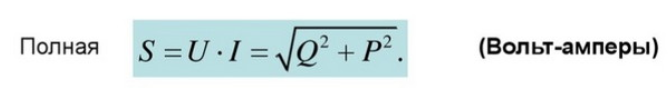

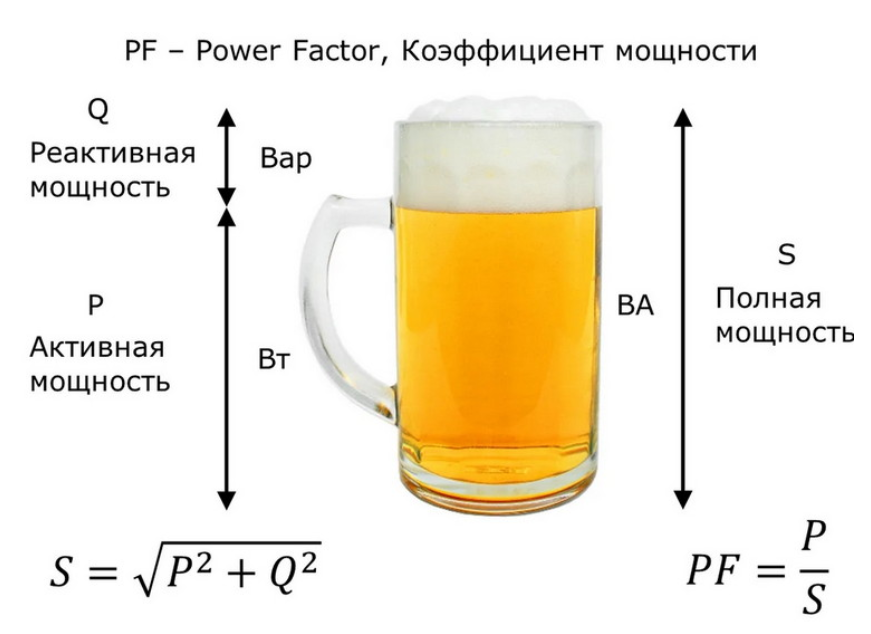

- Также есть период нагрева - время, возможно стоит рассчитать работу (S*dt) объединит в себе все эти параметры и тем самым мы уменьшим время обучения модели. Но нужно уточнить у заказчика стоит ли это делать.

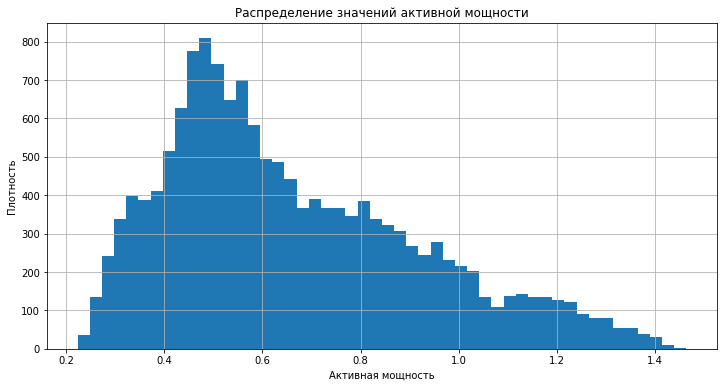

In [21]:
df_arc[['active_power']].hist(figsize=(12, 6), bins=50)
plt.xlabel('Активная мощность')
plt.ylabel('Плотность')
plt.title("Распределение значений активной мощности")
plt.show()

**Распределение значений активной мощности нормальное со смещением влево.**

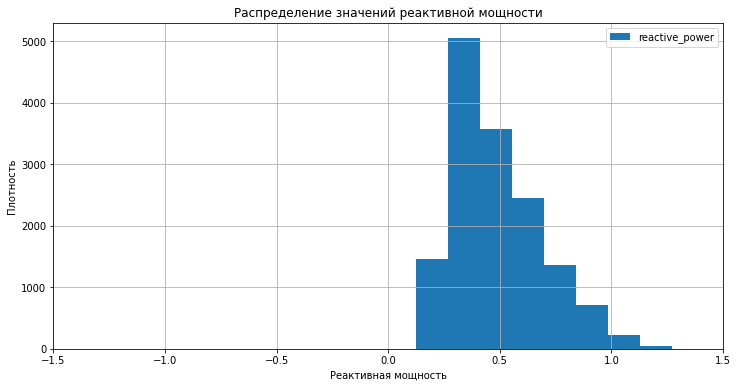

In [22]:
df_arc.plot(y='reactive_power', kind='hist', bins=5000, grid=True, figsize=(12, 6), xlim=(-1.5, 1.5))
plt.xlabel('Реактивная мощность')
plt.ylabel('Плотность')
plt.title("Распределение значений реактивной мощности")
plt.show()

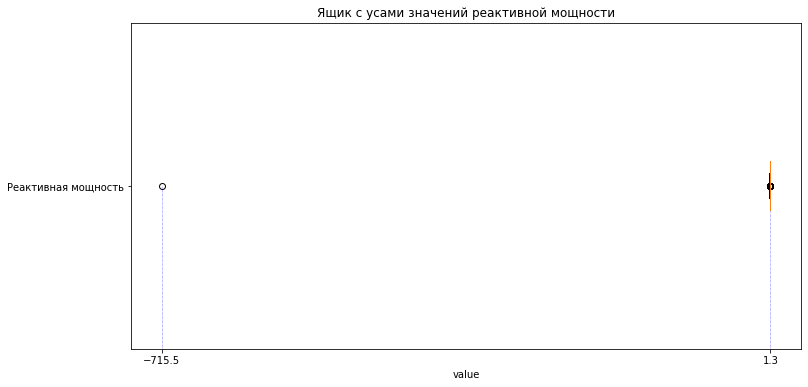

In [23]:
fig = plt.figure(1, figsize=(12, 6))
ax = fig.add_subplot(111)

ax.boxplot(df_arc['reactive_power'], vert=False, manage_ticks=True)
ax.set_xlabel('value')
ax.set_yticks([1])
ax.set_yticklabels(['Реактивная мощность'])

quantiles = np.quantile(df_arc['reactive_power'], np.array([0, 1.0]))
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.5, zorder=0)
ax.set_ylim(0.5, 1.5)
ax.set_xticks(quantiles)
plt.title("Ящик с усами значений реактивной мощности")
plt.show()

**Распределение значений реактивной мощности нормальное, присутствует выброс со значением -715,5, что скорее всего является ошибкой. В последующем удалим объекты с данным значением и объекты с таким же 'key', то есть всю партию, так как в дальнейшем уже будет некорректно ее использовать.**

In [24]:
# информация о датасете с данными о подаче сыпучих материалов (объёма)
df_info(df_bulk)

(3129, 16)

////////////////////////////////////////////////////////////////////////////////////////////////////
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
///////////////////////////////////////////////////////

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


////////////////////////////////////////////////////////////////////////////////////////////////////


'Доля пропусков по каждому столбцу:'

bulk_8     99.97
bulk_13    99.42
bulk_9     99.39
bulk_2     99.30
bulk_7     99.20
bulk_5     97.54
bulk_10    94.38
bulk_11    94.34
bulk_1     91.95
bulk_6     81.59
bulk_4     67.59
bulk_3     58.52
bulk_15    28.16
bulk_12    21.70
bulk_14    10.32
key         0.00
dtype: float64

////////////////////////////////////////////////////////////////////////////////////////////////////


'Количество дубликатов:'

0

////////////////////////////////////////////////////////////////////////////////////////////////////


2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

////////////////////////////////////////////////////////////////////////////////////////////////////


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


**Датасет состоит из 3129 объектов и 16 столбцов. В столбцах таблицы 'df_bulk' присутствует большое количество пропусков. Более 50% пропусков в столбцах Bulk (1-11,13). Возможно, их будет лучше объединить суммируя значения, но это необходимо уточнить у заказчика, либо заполнить пропуски нулями. Дубликатов нет. В столбце 'key' в каждой строке уникальные значения, то есть для каждой партий соответствует одна строка.**

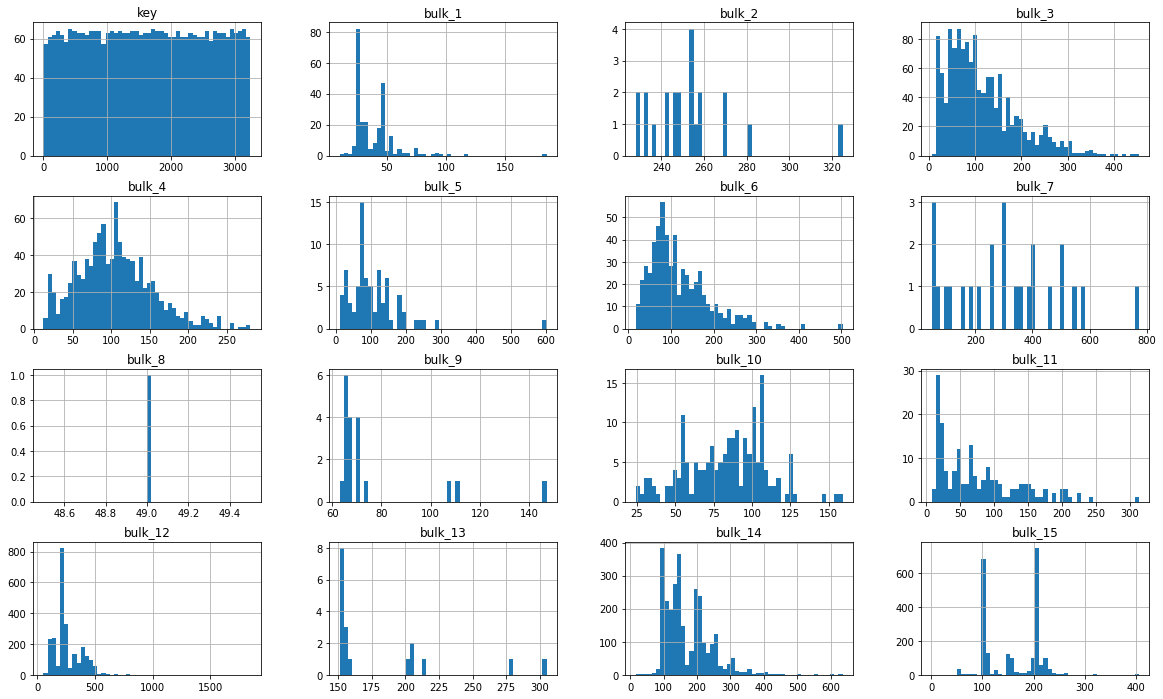

In [25]:
df_bulk.hist(figsize=(20, 12), bins=50);

In [26]:
# информация о датасете с  данными о подаче сыпучих материалов (время)
df_info(df_bulk_time)

(3129, 16)

////////////////////////////////////////////////////////////////////////////////////////////////////
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


////////////////////////////////////////////////////////////////////////////////////////////////////


'Доля пропусков по каждому столбцу:'

bulk_8     99.97
bulk_13    99.42
bulk_9     99.39
bulk_2     99.30
bulk_7     99.20
bulk_5     97.54
bulk_10    94.38
bulk_11    94.34
bulk_1     91.95
bulk_6     81.59
bulk_4     67.59
bulk_3     58.52
bulk_15    28.16
bulk_12    21.70
bulk_14    10.32
key         0.00
dtype: float64

////////////////////////////////////////////////////////////////////////////////////////////////////


'Количество дубликатов:'

0

////////////////////////////////////////////////////////////////////////////////////////////////////


2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

////////////////////////////////////////////////////////////////////////////////////////////////////


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


**Датасет 'df_bulk_time' состоит из 3129 объектов и 16 столбцов, также как и 'df_bulk'. Они соотносятся друг с другом поэтому их необходимо объединять в первую очередь.**

In [27]:
# информация о датасете с данными о продувке сплава газом
df_info(df_gas)

(3239, 2)

////////////////////////////////////////////////////////////////////////////////////////////////////
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
////////////////////////////////////////////////////////////////////////////////////////////////////


,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


////////////////////////////////////////////////////////////////////////////////////////////////////


'Доля пропусков по каждому столбцу:'

key    0.0
gas    0.0
dtype: float64

////////////////////////////////////////////////////////////////////////////////////////////////////


'Количество дубликатов:'

0

////////////////////////////////////////////////////////////////////////////////////////////////////


2049    1
3135    1
3115    1
1070    1
3119    1
       ..
2596    1
549     1
2600    1
553     1
2047    1
Name: key, Length: 3239, dtype: int64

////////////////////////////////////////////////////////////////////////////////////////////////////


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


**Датасет 'df_gas' состоит из 3239 объектов чуть меньше, чем количество партий (3241) и 2 столбцов. Пропусков в столбцах и дубликатов нет. В столбце 'key' в каждой строке уникальные значения, то есть для каждой партий соответствует одна строка.**

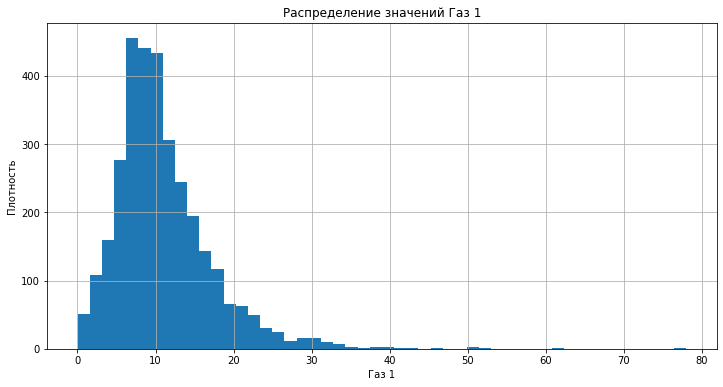

In [28]:
df_gas['gas'].hist(figsize=(12, 6), bins=50);
plt.xlabel('Газ 1')
plt.ylabel('Плотность')
plt.title("Распределение значений Газ 1")
plt.show()

**Распределение значенией газа нормальное.**

In [29]:
# информация о датасете с результатами измерения температуры
df_info(df_temp)

(18092, 3)

////////////////////////////////////////////////////////////////////////////////////////////////////
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        18092 non-null  int64         
 1   time_temp  18092 non-null  datetime64[ns]
 2   temp       14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB
////////////////////////////////////////////////////////////////////////////////////////////////////


,key,temp
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


////////////////////////////////////////////////////////////////////////////////////////////////////


'Доля пропусков по каждому столбцу:'

temp         18.94
key           0.00
time_temp     0.00
dtype: float64

////////////////////////////////////////////////////////////////////////////////////////////////////


'Количество дубликатов:'

0

////////////////////////////////////////////////////////////////////////////////////////////////////


2108    17
1513    16
1689    16
2567    15
322     14
        ..
556      2
1169     2
732      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

////////////////////////////////////////////////////////////////////////////////////////////////////


,key,time_temp,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


**Датасет 'df_temp' состоит из 18092 и 3 столбцов. Пропусков в столбце температуры почти 19%. Следует уточнить причину их отсутствия у заказчика. Почти для каждой партии есть несколько объектов как и в таблице 'df_arc'. В качестве таргета возможно необходимо будет брать последнее по времени значение температуры для каждой партии.**

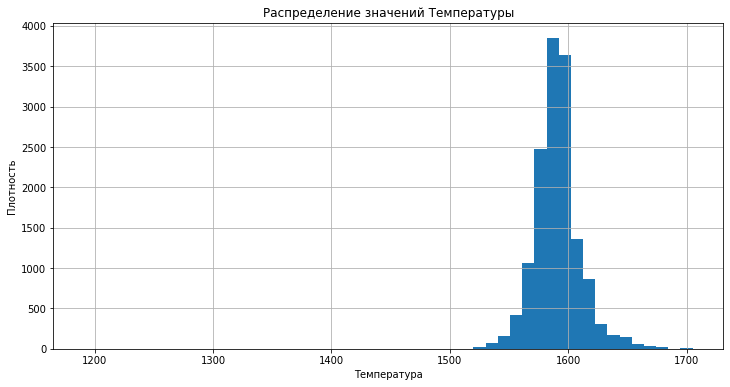

In [30]:
df_temp['temp'].hist(figsize=(12, 6), bins=50);
plt.xlabel('Температура')
plt.ylabel('Плотность')
plt.title("Распределение значений Температуры")
plt.show()

**Распеределение значений температуры нормальное.**

In [31]:
# информация о датасете с данными о проволочных материалах (объём)
df_info(df_wire)

(3081, 10)

////////////////////////////////////////////////////////////////////////////////////////////////////
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
////////////////////////////////////////////////////////////////////////////////////////////////////


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


////////////////////////////////////////////////////////////////////////////////////////////////////


'Доля пропусков по каждому столбцу:'

wire_5    99.97
wire_7    99.64
wire_4    99.55
wire_8    99.38
wire_9    99.06
wire_3    97.96
wire_6    97.63
wire_2    64.98
wire_1     0.84
key        0.00
dtype: float64

////////////////////////////////////////////////////////////////////////////////////////////////////


'Количество дубликатов:'

0

////////////////////////////////////////////////////////////////////////////////////////////////////


2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

////////////////////////////////////////////////////////////////////////////////////////////////////


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Датасет 'df_wire' состоит из 3081 объектов и 10 столбцов. В столбцах таблицы присутствует большое количество пропусков. Более 50% пропусков в столбцах wire (2-9). Возможно, их будет лучше объединить суммируя значения, но это необходимо уточнить у заказчика, либо заполнить пропуски нулями. Дубликатов нет. В столбце 'key' в каждой строке уникальные значения, то есть для каждой партий соответствует одна строка.**

In [32]:
# информация о датасете с данными о проволочных материалах (время)
df_info(df_wire_time)

(3081, 10)

////////////////////////////////////////////////////////////////////////////////////////////////////
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB
////////////////////////////////////////////////////////////////////////////////////////////////////


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


////////////////////////////////////////////////////////////////////////////////////////////////////


'Доля пропусков по каждому столбцу:'

wire_5    99.97
wire_7    99.64
wire_4    99.55
wire_8    99.38
wire_9    99.06
wire_3    97.96
wire_6    97.63
wire_2    64.98
wire_1     0.84
key        0.00
dtype: float64

////////////////////////////////////////////////////////////////////////////////////////////////////


'Количество дубликатов:'

0

////////////////////////////////////////////////////////////////////////////////////////////////////


2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

////////////////////////////////////////////////////////////////////////////////////////////////////


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


**Датасет 'df_wire_time' состоит из 3081 объектов и 10 столбцов, также как и 'df_wire'. Они соотносятся друг с другом поэтому их необходимо объединять в первую очередь.**

**ВЫВОД**

**Датасет 'df_arc' состоит из 14876 объектов и 5 столбцов. Период за который представленны данные - с 03.05.2019 по 06.09.2019 гг. пропусков и дубликатов нет.**

**Исходя из названий столбцов таблицы 'df_arc' электроды ковша питаются из сети переменного тока, так как присутствует активная и реактивная мощности.**

- Активная мощность (P) — это некая часть мощности, связанная непосредственно с трансформацией в какой-либо другой вид энергии. Она измеряется в ваттах (Вт).

- Реактивная мощность (Q) – это та часть мощности, которая вернется в сеть обратно. Более детально этот процесс можно описать так: это «вредоносный» процесс, который не полезен для всей системы, он характерен для устройств с нагрузкой индуктивного или емкостного типа. Эта часть мощности никак не помогает полезным процессам. Задача состоит в том, чтобы компенсировать реактивную мощность. Единица измерения реактивной мощности: вольт-амперы (Вар).

- Полная мощность (S) – это сочетание активной и неполезной реактивной:
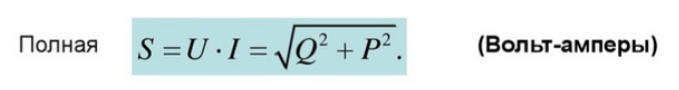

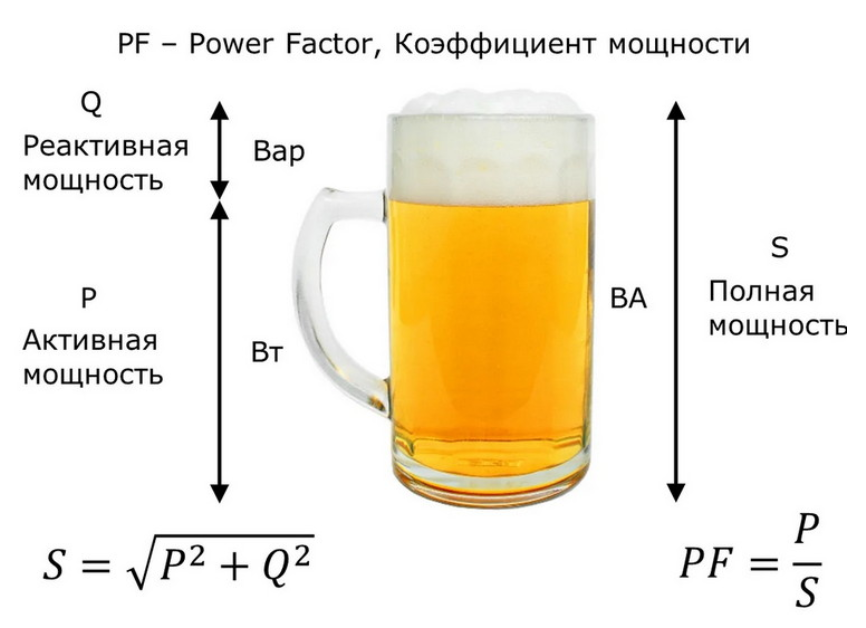

- Также есть период нагрева - время, возможно стоит рассчитать работу (S*dt) объединит в себе все эти параметры и тем самым мы уменьшим время обучения модели. Но нужно уточнить у заказчика стоит ли это делать.

- Распределение значений активной мощности нормальное со смещением влево.
- Распределение значений реактивной мощности нормальное, присутствует выброс со значением -715,5, что скорее всего является ошибкой. Необходимо уточнить у заказчика удалить ли данное значение, либо попросить предоставить корректное значение.


**Датасет 'df_bulk' состоит из 3129 объектов и 16 столбцов. В столбцах таблицы 'df_bulk' присутствует большое количество пропусков. Более 50% пропусков в столбцах Bulk (1-11,13). Возможно, их будет лучше объединить суммируя значения, но это необходимо уточнить у заказчика, либо заполнить пропуски нулями. Дубликатов нет. В столбце 'key' в каждой строке уникальные значения, то есть для каждой партий соответствует одна строка.**

**Датасет 'df_bulk_time' состоит из 3129 объектов и 16 столбцов, также как и 'df_bulk'. Они соотносятся друг с другом поэтому их необходимо объединять в первую очередь.**

**Датасет 'df_gas' состоит из 3239 объектов чуть меньше, чем количество партий (3241) и 2 столбцов. Пропусков в столбцах и дубликатов нет. В столбце 'key' в каждой строке уникальные значения, то есть для каждой партий соответствует одна строка. Распределение значенией газа нормальное.**

**Датасет 'df_temp' состоит из 18092 и 3 столбцов. Пропусков в столбце температуры почти 19%. Следует уточнить причину их отсутствия у заказчика. Почти для каждой партии есть несколько объектов как и в таблице 'df_arc'. В качестве таргета возможно необходимо будет брать последнее по времени значение температуры для каждой партии. Распеределение значений температуры нормальное.**

**Датасет 'df_wire' состоит из 3081 объектов и 10 столбцов. В столбцах таблицы присутствует большое количество пропусков. Более 50% пропусков в столбцах Bulk (2-9). Возможно, их будет лучше объединить суммируя значения, но это необходимо уточнить у заказчика, либо заполнить пропуски нулями. Дубликатов нет. В столбце 'key' в каждой строке уникальные значения, то есть для каждой партий соответствует одна строка.**

**Датасет 'df_wire_time' состоит из 3081 объектов и 10 столбцов, также как и 'df_wire'. Они соотносятся друг с другом поэтому их необходимо объединять в первую очередь.**

In [33]:
names

['df_arc',
 'df_bulk',
 'df_bulk_time',
 'df_gas',
 'df_temp',
 'df_wire',
 'df_wire_time']

In [34]:
display(df_arc.head(10))
df_temp.head(10)

,key,temp_start,temp_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


,key,time_temp,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


**1.2 Предобработка данных и свод таблиц**

In [35]:
# Посмотрим сколько объектов в таблице 'df_arc' с отрицательной реактивной мощностью
# и какие у них 'key'
df_arc.info()
df_arc[df_arc['reactive_power'] <= 0].describe()
df_arc[df_arc['key'] == 2116]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   temp_start      14876 non-null  datetime64[ns]
 2   temp_end        14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


,key,temp_start,temp_end,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


**Получилось, что всего лишь одно значение реактивной мощности отрицательное, но так как для партии №2116 несколько объектов в таблице, то нужно удалить их все.**

In [36]:
df_arc = df_arc.query('key != 2116').reset_index(drop=True)
df_arc.head(10)

,key,temp_start,temp_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [37]:
df_arc.info()
df_arc[df_arc['key'] == 2116]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14872 entries, 0 to 14871
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14872 non-null  int64         
 1   temp_start      14872 non-null  datetime64[ns]
 2   temp_end        14872 non-null  datetime64[ns]
 3   active_power    14872 non-null  float64       
 4   reactive_power  14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.1 KB


,key,temp_start,temp_end,active_power,reactive_power


**Далее создадим столбец с общей мощностью и временем нагрева (в секундах) за цикл.**

In [38]:
df_arc['total_power'] = round((df_arc['active_power']**2+df_arc['reactive_power']**2)**0.5,6)
df_arc['total_time'] = (df_arc['temp_end']-df_arc['temp_start']).dt.total_seconds().astype(int)

In [39]:
display(df_arc.head(10))
df_arc.info()

,key,temp_start,temp_end,active_power,reactive_power,total_power,total_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,0.440239,137
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,0.332731,338
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,0.860064,126
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,0.955315,210
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,1.373863,280


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14872 entries, 0 to 14871
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14872 non-null  int64         
 1   temp_start      14872 non-null  datetime64[ns]
 2   temp_end        14872 non-null  datetime64[ns]
 3   active_power    14872 non-null  float64       
 4   reactive_power  14872 non-null  float64       
 5   total_power     14872 non-null  float64       
 6   total_time      14872 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(2)
memory usage: 813.4 KB


**Внутри каждой партии суммируем 'total_power' и 'total_time' и оставим только один объект для каждой партии с суммарными этими параметрами, тоесть создадим новую таблицу 'df_arc_agg'.**

In [40]:
df_arc_agg = df_arc.groupby('key').agg({'total_power': ['sum'], 'total_time': ['sum']}).reset_index(drop=False)

In [41]:
display(df_arc_agg.head(10))
display(df_arc_agg['key'].value_counts())

,key,total_power,total_time
,,sum,sum
0,1,3.718736,1098
1,2,2.588349,811
2,3,5.019224,655
3,4,3.400038,741
4,5,2.816980,869
5,6,3.313074,952
6,7,3.283913,673
7,8,3.405957,913
8,9,4.335261,625


2049    1
1090    1
1070    1
3119    1
1074    1
       ..
2592    1
545     1
2596    1
549     1
2047    1
Name: key, Length: 3213, dtype: int64

In [42]:
#Удалим нижний уровень названий столбцов
df_arc_agg.columns = df_arc_agg.columns.droplevel(1)

In [43]:
df_arc_agg.info()
display(df_arc_agg.head(2))
display(df_arc_agg['key'].value_counts().head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3213 non-null   int64  
 1   total_power  3213 non-null   float64
 2   total_time   3213 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 75.4 KB


,key,total_power,total_time
0,1,3.718736,1098
1,2,2.588349,811


2049    1
1090    1
Name: key, dtype: int64

**Все сработало таблица 'df_arc_agg' готова к объединению. 'total_power' и 'total_time' будем использовать в качестве признаков в модели прогнозирования конечной температуры. Далее подготовим следующие таблицы.**

**В таблице 'df_bulk' заполним пропуски нулями, а параметры, в которых более 50% пропусков (как уже было выявлено ранее, это столбцы bulk 1-11,13), объединим в один параметр 'bulk_1-11_13' суммируя значения.**

In [44]:
# в таблице 'df_bulk' заполним пропуски нулями
df_bulk = df_bulk.fillna(0)
display(df_bulk.isna().sum())
display(df_bulk.head(4))

key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0


In [45]:
#просуммируем столбцы Bulk (1-11,13)
df_bulk['bulk_1-11_13'] = df_bulk.iloc[:, list(range(1,12))].sum(axis=1) + df_bulk.iloc[:, 13]
display(df_bulk.head(2))

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_1-11_13
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,43.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,73.0


**Создадим новую таблицу 'df_bulk_agg', подготовленную для объединения.**

In [46]:
df_bulk_agg = df_bulk.loc[:, ['key', 'bulk_12', 'bulk_14', 'bulk_15', 'bulk_1-11_13']]
display(df_bulk_agg.head(2))

,key,bulk_12,bulk_14,bulk_15,bulk_1-11_13
0,1,206.0,150.0,154.0,43.0
1,2,206.0,149.0,154.0,73.0


**Таблицы 'df_bulk_time' и 'df_wire_time' нам не пригодятся для решения поставленной задачи, поэтому их использовать не будем. Таблицу 'df_wire' обработаем также как и 'df_bulk'.**

In [47]:
# в таблице 'df_wire' заполним пропуски нулями
df_wire = df_wire.fillna(0)
display(df_wire.isna().sum())
display(df_wire.head(2))

key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
#просуммируем столбцы wire(2-9)
df_wire['wire_2-9'] = df_wire.iloc[:, list(range(2,10))].sum(axis=1)
display(df_wire.head(2))

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_2-9
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Создадим новую таблицу 'df_wire_agg', подготовленную для объединения.**

In [49]:
df_wire_agg = df_wire.loc[:, ['key', 'wire_1', 'wire_2-9']]
display(df_wire_agg.head(2))

,key,wire_1,wire_2-9
0,1,60.059998,0.0
1,2,96.052315,0.0


In [50]:
#Таблица 'df_gas' в целом готова к слиянию сделаем ее копию с другим названием 'df_gas_agg', то есть приведем к единообразию
df_gas_agg = df_gas.copy()

In [51]:
df_gas_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


**Температура плавления стали составляет 1400 градусов Цельсия, в датасете 'df_temp' присутствуют значения ниже этой температуры, удалим партии, где есть такая температура.**

In [52]:
df_temp.info()
len(df_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        18092 non-null  int64         
 1   time_temp  18092 non-null  datetime64[ns]
 2   temp       14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


18092

In [53]:
display(df_temp[df_temp['temp'] < 1400])
len(df_temp[(df_temp['key'] == 867) | (df_temp['key'] == 1214) | (df_temp['key'] == 1619) \
        | (df_temp['key'] == 2052) | (df_temp['key'] == 2561)])

,key,time_temp,temp
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


27

In [54]:
#Удаляем партии, в которых хотябы раз была температура ниже 1400 градусов
df_temp_agg = df_temp.drop(df_temp.groupby('key').filter(lambda x: (x['temp'] < 1400).any()).index)

In [55]:
df_temp_agg[(df_temp_agg['key'] == 867) | (df_temp_agg['key'] == 1214) \
            | (df_temp_agg['key'] == 1619) | (df_temp_agg['key'] == 2052) | (df_temp_agg['key'] == 2561)]

,key,time_temp,temp


In [56]:
df_temp_agg = df_temp_agg.reset_index(drop=True)
df_temp_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18065 entries, 0 to 18064
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        18065 non-null  int64         
 1   time_temp  18065 non-null  datetime64[ns]
 2   temp       14643 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 423.5 KB


**Теперь приведем таблицу к виду 'партия - начальная температура - последняя температура', пропуски пока обрабатывать не будем.**

In [57]:
display(df_temp_agg.tail(20))
print(df_temp_agg.isna().sum())
len(df_temp_agg)

,key,time_temp,temp
18045,3239,2019-09-06 14:22:49,NaN
18046,3239,2019-09-06 14:28:54,NaN
18047,3239,2019-09-06 14:33:34,NaN
18048,3239,2019-09-06 14:42:48,NaN
18049,3239,2019-09-06 14:56:58,NaN
18050,3239,2019-09-06 14:59:25,NaN
18051,3239,2019-09-06 15:03:35,NaN
18052,3239,2019-09-06 15:09:55,NaN
18053,3240,2019-09-06 15:25:21,1617.0
18054,3240,2019-09-06 15:30:52,NaN


key             0
time_temp       0
temp         3422
dtype: int64


18065

In [58]:
#Удалим партии, где есть хотябы однон пропущенное значение температуры
df_temp_agg = df_temp_agg.groupby('key').filter(lambda x: x['temp'].notnull().all())

In [59]:
display(df_temp_agg.tail(20))
print(df_temp_agg.isna().sum())
len(df_temp_agg)

,key,time_temp,temp
13885,2496,2019-08-10 12:04:46,1595.0
13886,2496,2019-08-10 12:10:21,1583.0
13887,2496,2019-08-10 12:15:29,1584.0
13888,2496,2019-08-10 12:19:09,1580.0
13889,2496,2019-08-10 12:25:13,1591.0
13890,2497,2019-08-10 12:37:26,1571.0
13891,2497,2019-08-10 12:42:22,1577.0
13892,2497,2019-08-10 12:47:44,1576.0
13893,2497,2019-08-10 12:53:28,1589.0
13894,2498,2019-08-10 12:58:11,1591.0


key          0
time_temp    0
temp         0
dtype: int64


13905

In [60]:
# На всякий случай выполним сортировку по дате и по партии, 
# чтобы в таблице в каждой партии температура регистрировалась в хронологическом порядке.
df_temp_agg = df_temp_agg.sort_values(['time_temp', 'key']).reset_index(drop=True)

In [61]:
display(df_temp_agg.head(20))
display(df_temp_agg.tail(20))

,key,time_temp,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


,key,time_temp,temp
13885,2496,2019-08-10 12:04:46,1595.0
13886,2496,2019-08-10 12:10:21,1583.0
13887,2496,2019-08-10 12:15:29,1584.0
13888,2496,2019-08-10 12:19:09,1580.0
13889,2496,2019-08-10 12:25:13,1591.0
13890,2497,2019-08-10 12:37:26,1571.0
13891,2497,2019-08-10 12:42:22,1577.0
13892,2497,2019-08-10 12:47:44,1576.0
13893,2497,2019-08-10 12:53:28,1589.0
13894,2498,2019-08-10 12:58:11,1591.0


In [62]:
df_temp_agg_first = df_temp_agg.groupby('key').agg({'temp': ['first']}).reset_index(drop=False)
df_temp_agg_last = df_temp_agg.groupby('key').agg({'temp': ['last']}).reset_index(drop=False)

In [63]:
display(df_temp_agg_first.tail(20))
df_temp_agg_last.tail(20)

,key,temp
,,first
2453,2479,1576.0
2454,2480,1556.0
2455,2481,1559.0
2456,2482,1569.0
2457,2483,1598.0
2458,2484,1635.0
2459,2485,1582.0
2460,2486,1589.0
2461,2487,1568.0


,key,temp
,,last
2453,2479,1601.0
2454,2480,1595.0
2455,2481,1598.0
2456,2482,1598.0
2457,2483,1598.0
2458,2484,1592.0
2459,2485,1616.0
2460,2486,1592.0
2461,2487,1583.0


In [64]:
df_temp_agg = df_temp_agg_first.merge(df_temp_agg_last, on='key', how='inner')
df_temp_agg.tail(20)

key    temp        
             first    last
2453  2479  1576.0  1601.0
2454  2480  1556.0  1595.0
2455  2481  1559.0  1598.0
2456  2482  1569.0  1598.0
2457  2483  1598.0  1598.0
2458  2484  1635.0  1592.0
2459  2485  1582.0  1616.0
2460  2486  1589.0  1592.0
2461  2487  1568.0  1583.0
2462  2488  1602.0  1577.0
2463  2489  1613.0  1579.0
2464  2490  1602.0  1619.0
2465  2492  1618.0  1595.0
2466  2493  1599.0  1594.0
2467  2494  1585.0  1591.0
2468  2495  1570.0  1591.0
2469  2496  1554.0  1591.0
2470  2497  1571.0  1589.0
2471  2498  1591.0  1594.0
2472  2499  1569.0  1603.0

In [65]:
df_temp_agg.columns = df_temp_agg.columns.droplevel(1)
df_temp_agg.columns.values[1] = 'first_temp'
df_temp_agg.columns.values[2] = 'last_temp'

In [66]:
df_temp_agg.head(3)

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0


In [67]:
new_names = ['df_arc_agg', 'df_bulk_agg', 'df_wire_agg', 'df_gas_agg', 'df_temp_agg']
print("df_temp_agg")
df_temp_agg.info()
print(100*"/")
print("df_arc_agg")
df_arc_agg.info()
print(100*"/")
print("df_bulk_agg")
df_bulk_agg.info()
print(100*"/")
print("df_wire_agg")
df_wire_agg.info()
print(100*"/")
print("df_gas_agg")
df_gas_agg.info()

df_temp_agg
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2472
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2473 non-null   int64  
 1   first_temp  2473 non-null   float64
 2   last_temp   2473 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.3 KB
////////////////////////////////////////////////////////////////////////////////////////////////////
df_arc_agg
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3213 non-null   int64  
 1   total_power  3213 non-null   float64
 2   total_time   3213 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 75.4 KB
////////////////////////////////////////////////////////////////////////////////////////////////////
df_bulk_agg
<class 'pandas.core.frame.DataFram

**Пропущенных значениц нет, поэтому приступим к объединению таблиц.**

In [68]:
#Проверим какая таблица наименьшая
new_dfs = [df_arc_agg, df_bulk_agg, df_wire_agg, df_gas_agg, df_temp_agg]
min_len = 10000
for i in new_dfs:
    if len(i) < min_len:
        min_len = len(i)
        df_min = i.head()
        
print(df_min)
print('Длина наименьшего датафрейма', min_len)

   key  first_temp  last_temp
0    1      1571.0     1613.0
1    2      1581.0     1602.0
2    3      1596.0     1599.0
3    4      1601.0     1625.0
4    5      1576.0     1602.0
Длина наименьшего датафрейма 2473


**Получилось, что наименьшее количество партий в таблице 'df_temp_agg', их 2473.**
**Объединять будем методом '.merge()' с атрибутом 'how' принимающим значение 'inner', так мы получим партии для которых есть информация во всех таблицах.**

In [69]:
df_full = df_temp_agg.merge(df_arc_agg, on='key', how='inner')
df_full = df_full.merge(df_gas_agg, on='key', how='inner')
df_full = df_full.merge(df_bulk_agg, on='key', how='inner')
df_full = df_full.merge(df_wire_agg, on='key', how='inner')

In [70]:
display(df_full['key'].value_counts())
df_full.isna().sum()

2049    1
407     1
429     1
2478    1
431     1
       ..
1224    1
1226    1
1228    1
1230    1
2047    1
Name: key, Length: 2324, dtype: int64

key             0
first_temp      0
last_temp       0
total_power     0
total_time      0
gas             0
bulk_12         0
bulk_14         0
bulk_15         0
bulk_1-11_13    0
wire_1          0
wire_2-9        0
dtype: int64

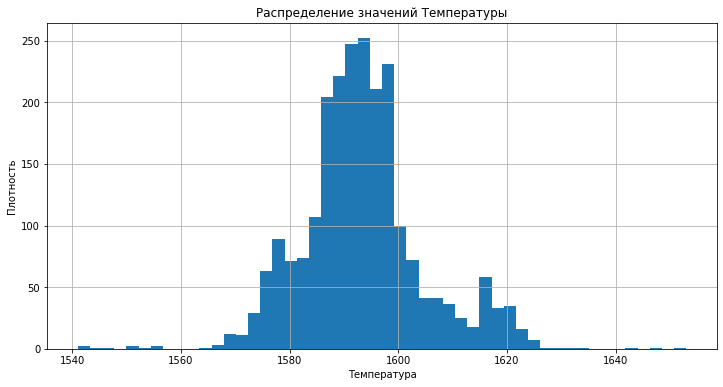

In [71]:
df_full['last_temp'].hist(figsize=(12, 6), bins=50);
plt.xlabel('Температура')
plt.ylabel('Плотность')
plt.title("Распределение значений Температуры")
plt.show()

In [72]:
df_full.info()
df_full.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2324 non-null   int64  
 1   first_temp    2324 non-null   float64
 2   last_temp     2324 non-null   float64
 3   total_power   2324 non-null   float64
 4   total_time    2324 non-null   int64  
 5   gas           2324 non-null   float64
 6   bulk_12       2324 non-null   float64
 7   bulk_14       2324 non-null   float64
 8   bulk_15       2324 non-null   float64
 9   bulk_1-11_13  2324 non-null   float64
 10  wire_1        2324 non-null   float64
 11  wire_2-9      2324 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 236.0 KB


,key,first_temp,last_temp,total_power,total_time,gas,bulk_12,bulk_14,bulk_15,bulk_1-11_13,wire_1,wire_2-9
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,1251.140275,1587.368761,1593.372633,3.886143,808.196644,11.378854,208.597676,153.952668,120.078313,127.454389,102.423900,22.779374
std,715.027927,23.627590,11.207457,1.517584,340.813828,6.397008,157.112117,81.410544,84.655967,112.337931,43.540975,49.147126
min,1.000000,1519.000000,1541.000000,0.331897,57.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,628.750000,1571.000000,1587.000000,2.846892,581.000000,7.282534,105.000000,105.000000,0.000000,62.000000,73.204559,0.000000
50%,1254.500000,1587.000000,1593.000000,3.770583,778.000000,10.100687,206.000000,149.000000,107.000000,107.000000,101.103600,0.000000
75%,1867.250000,1603.000000,1598.000000,4.769754,993.000000,14.218487,283.000000,204.000000,204.000000,165.250000,128.075222,27.196780
max,2499.000000,1660.000000,1653.000000,15.288270,4189.000000,77.995040,1849.000000,636.000000,405.000000,1276.000000,330.314424,407.146108


**Проверим признаки на мультиколлинеарность, если признаки коррелируют с коэффициентом корреляции равным более 0,9, то один из признаков удаляем.**

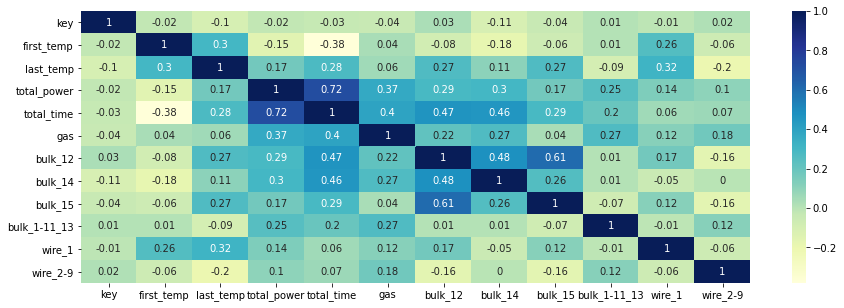

In [73]:
plt.figure(figsize=(15, 5))
sns.heatmap(df_full.corr().round(2), cmap="YlGnBu", annot=True)
plt.show()

**Коэффициентов корреляции более 0,9 нет, поэтому оставляем все признаки в итоговом датафрейме. Далее приступим к выделению целевого признака и признаков, выделению обучающей и тестовой выборок.**

**1.3 Подготовка выборок**

In [74]:
# Зафиксируем генератор кросс-валидации cv
MY_CV = 3

In [75]:
#Разделим датафрейм на признаки (features) и целевую переменную (target)
features = df_full.drop(['key', 'last_temp'], axis=1)
target = df_full['last_temp']

In [76]:
display(features)
display(target)

,first_temp,total_power,total_time,gas,bulk_12,bulk_14,bulk_15,bulk_1-11_13,wire_1,wire_2-9
0,1571.0,3.718736,1098,29.749986,206.0,150.0,154.0,43.0,60.059998,0.00000
1,1581.0,2.588349,811,12.555561,206.0,149.0,154.0,73.0,96.052315,0.00000
2,1596.0,5.019224,655,28.554793,205.0,152.0,153.0,34.0,91.160157,0.00000
3,1601.0,3.400038,741,18.841219,207.0,153.0,154.0,81.0,89.063515,0.00000
4,1576.0,2.816980,869,5.413692,203.0,151.0,152.0,78.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...
2319,1570.0,3.868721,723,7.125735,256.0,129.0,223.0,111.0,89.150879,0.00000
2320,1554.0,5.070316,940,9.412616,256.0,129.0,226.0,185.0,114.179527,0.00000
2321,1571.0,4.360917,569,6.271699,230.0,124.0,226.0,85.0,94.086723,9.04800
2322,1591.0,3.909917,750,14.953657,206.0,129.0,207.0,191.0,118.110717,0.00000


0       1613.0
1       1602.0
2       1599.0
3       1625.0
4       1602.0
         ...  
2319    1591.0
2320    1591.0
2321    1589.0
2322    1594.0
2323    1603.0
Name: last_temp, Length: 2324, dtype: float64

In [77]:
# разделяем на обучающую и тестовую выборки (75/25)
features_train, features_test, target_train, target_test  = train_test_split(features, 
                                                                             target, 
                                                                             test_size=0.25,
                                                                             random_state=RS)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(1743, 10)
(1743,)
(581, 10)
(581,)


In [82]:
#Выполним масштабирование признаков
scaler = StandardScaler()    
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

## Обучение моделей

**2.1 Обучим модель линейной регрессии.**

In [78]:
%%time

model_linear = LinearRegression()
best_score_linear = round(abs(cross_val_score(model_linear, features_train, target_train, \
                                    cv=MY_CV, scoring='neg_mean_absolute_error')).mean(), 2)

print('"MAE" на модели линейной регрессии:', best_score_linear)

"MAE" на модели линейной регрессии: 6.69
CPU times: user 56 ms, sys: 76.7 ms, total: 133 ms
Wall time: 48.3 ms


**2.2 Обучим модель случайного леса.**

In [80]:
parameters_forest = {'n_estimators': range(200, 501, 100),
                     'max_depth': range(1, 17, 2)}

In [81]:
%%time

model_forest = RandomForestRegressor(random_state=RS)
grid_forest = GridSearchCV(model_forest, parameters_forest, cv=MY_CV, scoring='neg_mean_absolute_error')
grid_forest.fit(features_train, target_train)

CPU times: user 1min 1s, sys: 229 ms, total: 1min 1s
Wall time: 1min 2s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=161023),
             param_grid={'max_depth': range(9, 17, 2),
                         'n_estimators': range(400, 501, 100)},
             scoring='neg_mean_absolute_error')

In [82]:
best_parameters_forest = grid_forest.best_params_
means = grid_forest.cv_results_['mean_test_score']
best_score_forest = round(grid_forest.best_score_*-1, 2)
print('Лучшие гиперпараметры для модели случайного леса:', best_parameters_forest)
print('"MAE" для случайного леса:', best_score_forest)

Лучшие гиперпараметры для модели случайного леса: {'max_depth': 9, 'n_estimators': 500}
"MAE" для случайного леса: 6.65


**2.3 Обучим модель CatBoostRegressor.**

In [87]:
parameters_cbr = {'learning_rate': np.logspace(-2, 0, 4),
                  'depth': range(10, 41, 10),
                  'n_estimators': range(1, 201, 20)}

In [88]:
%%time

grid_cbr = GridSearchCV(CatBoostRegressor(loss_function='MAE',                                          
                                          verbose=False,                                                                                                                           
                                          random_state=RS),
                        parameters_cbr,
                        scoring='neg_mean_absolute_error',
                        cv=MY_CV)
grid_cbr.fit(features_train, target_train)

CPU times: user 4min 46s, sys: 2.67 s, total: 4min 48s
Wall time: 7min 38s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f29a0c26880>,
             param_grid={'depth': range(10, 41, 10),
                         'learning_rate': array([0.01      , 0.04641589, 0.21544347, 1.        ]),
                         'n_estimators': range(1, 201, 20)},
             scoring='neg_mean_absolute_error')

In [89]:
best_parameters_cbr = grid_cbr.best_params_
best_score_cbr = round(grid_cbr.best_score_*-1, 2)
print('Лучшие гиперпараметры для модели CatBoostRegressor:', best_parameters_cbr)
print('"MAE" для CatBoostRegressor:', best_score_cbr)

Лучшие гиперпараметры для модели CatBoostRegressor: {'depth': 10, 'learning_rate': 0.046415888336127774, 'n_estimators': 141}
"MAE" для CatBoostRegressor: 6.93


**2.4 Обучим модель LGBMRegressor.**

In [90]:
parameters_lgbm = { 'max_depth': range(10, 31, 10),
                   'n_estimators': range(10, 51, 10)}

In [91]:
%%time
grid_lgbm = GridSearchCV(LGBMRegressor(random_state=RS), parameters_lgbm, scoring='neg_mean_absolute_error', cv=MY_CV)
grid_lgbm.fit(features_train, target_train)

CPU times: user 5.21 s, sys: 128 ms, total: 5.34 s
Wall time: 5.27 s


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=161023),
             param_grid={'max_depth': range(10, 31, 10),
                         'n_estimators': range(10, 51, 10)},
             scoring='neg_mean_absolute_error')

In [92]:
best_parameters_lgbm = grid_lgbm.best_params_
best_score_lgbm = round(grid_lgbm.best_score_*-1, 2)
print('Лучшие гиперпараметры для модели LGBMRegressor:', best_parameters_lgbm)
print('"MAE" для LGBMRegressor:', best_score_lgbm)

Лучшие гиперпараметры для модели LGBMRegressor: {'max_depth': 10, 'n_estimators': 30}
"MAE" для LGBMRegressor: 6.73


In [102]:
#занесем результаты в отдельный датафрейм
model_type = ['Linear Regression', 'Random Forest Regressor', 'CatBoostRegressor', 'LGBMRegressor']
MAE = [best_score_linear, best_score_forest, best_score_cbr, best_score_lgbm]



result = pd.DataFrame({'Model Type': model_type,
                           'MAE': MAE})

result

,Model Type,MAE
0,Linear Regression,6.69
1,Random Forest Regressor,6.65
2,CatBoostRegressor,6.93
3,LGBMRegressor,6.73


## Тестирование лучшей модели

In [94]:
%%time
# Лучшие гиперпараметры для модели случайного леса: {'max_depth': 9, 'n_estimators': 500}

best_model_forest = RandomForestRegressor(random_state=RS, n_estimators=500, max_depth=9)
best_model_forest.fit(features_train, target_train)
prediction_forest = best_model_forest.predict(features_test)
best_score_forest_test = round(mean_absolute_error(target_test, prediction_forest),2)

print("'MAE' на модели случайного леса на тестовой выборке:", best_score_forest_test)

'MAE' на модели случайного леса на тестовой выборке: 6.1
CPU times: user 3.65 s, sys: 19.9 ms, total: 3.67 s
Wall time: 3.68 s


In [95]:
explainer = shap.Explainer(best_model_forest, feature_names=features.columns)
shap_values = explainer(features_train)

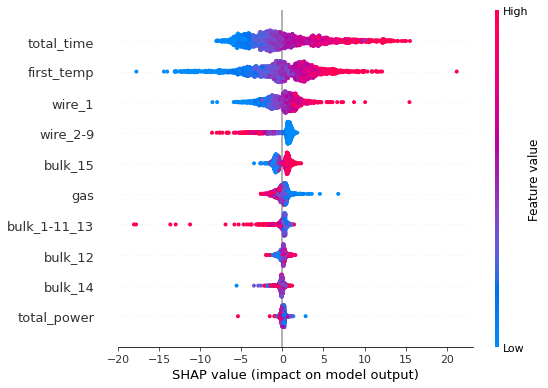

In [96]:
shap.summary_plot(shap_values, features_train)

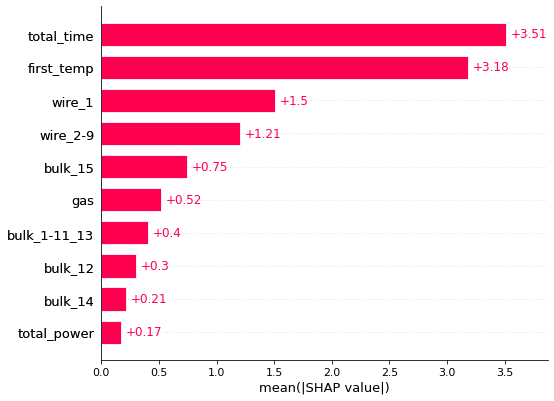

In [97]:
shap.plots.bar(shap_values)

- Значительное влияние на конечную температуру 'last_temp' оказывают параметры общего времени нагрева дугой 'total_time' и начальной температуры сплава после первого нагрева 'first_temp'. При более высоких их значениях будут наблюдаться более высокие значения конечной температуры.
- Также умеренное влияние на конечную температуру 'last_temp' оказывают параметры объема добавок проволочных материалов 'wire_1' и 'wire_2-9'. При более высоких объемах первой добавки будут наблюдаться более высокие значения конечной температуры. И наоборот, при более высоких объемах остальных добавок проволочных материалов будут наблюдаться более низкие значения конечной температуры.
- Остальные признаки можно считать оказывающими незначительное влияние на целевой признак.

In [98]:
model_dummy = DummyRegressor(strategy="median")
model_dummy.fit(features_train, target_train)
dummy_pred = model_dummy.predict(features_test)
mae_dummy = round(mean_absolute_error(target_test, dummy_pred),2)

print("'MAE' на dummy модели:", mae_dummy)

'MAE' на dummy модели: 7.61


**MAE на Dummy модели 7,61, что больше чем на лучшей модели, то есть наша модель прошла тест на адекватность.**

## Вывод

**В результате анализа общей информации выявлено следующее:**

**Датасет 'df_arc' состоит из 14876 объектов и 5 столбцов. Период, за который представленны данные - с 03.05.2019 по 06.09.2019 гг. пропусков и дубликатов нет.**

**Исходя из названий столбцов таблицы 'df_arc' электроды ковша питаются из сети переменного тока, так как присутствует активная и реактивная мощности.**

- Активная мощность (P) — это некая часть мощности, связанная непосредственно с трансформацией в какой-либо другой вид энергии. Она измеряется в ваттах (Вт).

- Реактивная мощность (Q) – это та часть мощности, которая вернется в сеть обратно. Более детально этот процесс можно описать так: это «вредоносный» процесс, который не полезен для всей системы, он характерен для устройств с нагрузкой индуктивного или емкостного типа. Эта часть мощности никак не помогает полезным процессам. Задача состоит в том, чтобы компенсировать реактивную мощность. Единица измерения реактивной мощности: вольт-амперы (Вар).

- Полная мощность (S) – это сочетание активной и неполезной реактивной:
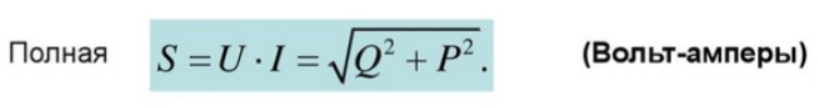

- Также есть период нагрева - время, возможно стоит рассчитать работу (S*dt) объединит в себе все эти параметры и тем самым мы уменьшим время обучения модели. Но нужно уточнить у заказчика стоит ли это делать.

- Распределение значений активной мощности нормальное со смещением влево.
- Распределение значений реактивной мощности нормальное, присутствует выброс со значением -715,5, что скорее всего является ошибкой. Необходимо уточнить у заказчика удалить ли данное значение, либо попросить предоставить корректное значение.
**В качестве признаков выделены суммарная по партии полная мощность и сумма времени нагрева для каждой партии.**

**Датасет 'df_bulk' состоит из 3129 объектов и 16 столбцов. В столбцах таблицы 'df_bulk' присутствует большое количество пропусков. Более 50% пропусков в столбцах Bulk (1-11,13). Они объеденены в столбец 'bulk_1-11_13' в качестве признака, пропуски заполнены нулями. В столбце 'key' в каждой строке уникальные значения, то есть для каждой партий соответствует одна строка.**

**Датасет 'df_bulk_time' состоит из 3129 объектов и 16 столбцов, также как и 'df_bulk'. Данный датафрейм не использовался.**

**Датасет 'df_gas' состоит из 3239 объектов чуть меньше, чем количество партий (3241) и 2 столбцов. Пропусков в столбцах и дубликатов нет. В столбце 'key' в каждой строке уникальные значения, то есть для каждой партий соответствует одна строка. Распределение значенией газа нормальное.**

**Датасет 'df_temp' состоит из 18092 и 3 столбцов. Пропусков в столбце температуры почти 19%. Все партии в которых есть хотябы один пропуск были удалены. В качестве таргета взяты значения конечной температуры по партии, начальная температура выделена в качестве признака. Распеределение значений температуры нормальное.**

**Датасет 'df_wire' состоит из 3081 объектов и 10 столбцов. В столбцах таблицы присутствует большое количество пропусков. Более 50% пропусков в столбцах Bulk (2-9), они объеденены в один признак 'wire_2-9'. Пропускизаполнены нулями. Дубликатов нет. В столбце 'key' в каждой строке уникальные значения, то есть для каждой партий соответствует одна строка.**

**Датасет 'df_wire_time' состоит из 3081 объектов и 10 столбцов. Данный датафрейм не использовался.**

**В результате предобработки данных выполнено следующее:**
- Удалена партия в которой есть отрицательное значение реактивной мощности.
- Созданы столбцы с общей мощностью 'total_power' и временем нагрева 'total_time' в качестве признаков, внутри каждой партии просуммированы значения этих параметров и занесены в таблицу 'df_arc_agg'.
- Создана новая таблица 'df_bulk_agg', в которую занесены параметры 'bulk_12', 'bulk_14', 'bulk_15' и суммирующий признак 'bulk_1-11_13'.
- Создана новая таблица 'df_wire_agg', в которую занесен признак 'wire_1' и суммирующий признак 'wire_2-9'.
- Из таблицы 'df_temp' удалены партии ,в которых есть значения температуры менее 1400 градусов цельсия, что ниже температуры плавления стали. Удалены партии, в которых есть хотябы один пропуск. Выделены начальная температура 'first_temp' в качестве признака и конечнаяя температура 'last_temp' в качестве целевого признака (таргета).
- Таблицы 'df_bulk_time' и 'df_wire_time' не использовались.

**Все таблицы объеденены методом merge() по столбцу 'key' с атрибутом 'how' со значением 'inner'.**

**Признаки проверены на мультиколлинеарность, сильнокоррелирующих между собой признаков нет.**


**Модели**
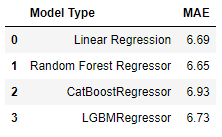

- В результате обучения моделей наилучшей оказалась модель RandomForestRegressor со следующими гиперпараметрами: количество деревьев 'Estimators' лучшей модели - 500, глубина 'Max_depth' лучшей модели - 9.

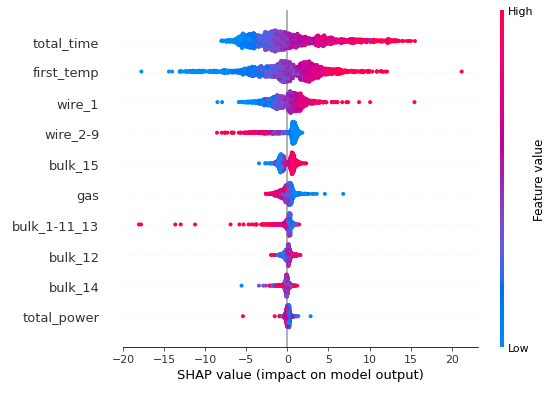
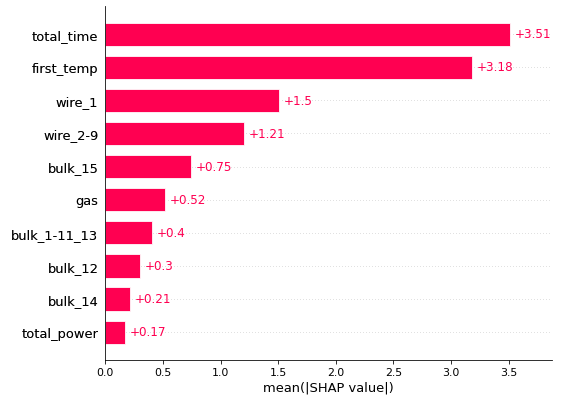

- Значительное влияние на конечную температуру 'last_temp' оказывают параметры общего времени нагрева дугой 'total_time' и начальной температуры сплава после первого нагрева 'first_temp'. При более высоких их значениях будут наблюдаться более высокие значения конечной температуры.
- Также умеренное влияние на конечную температуру 'last_temp' оказывают параметры объема добавок проволочных материалов 'wire_1' и 'wire_2-9'. При более высоких объемах первой добавки будут наблюдаться более высокие значения конечной температуры. И наоборот, при более высоких объемах остальных добавок проволочных материалов будут наблюдаться более низкие значения конечной температуры.
- Остальные признаки можно считать оказывающими незначительное влияние на целевой признак.
- Финальная оценка MAE на тестовой выборке составила 6,1, что меньше необходимого значения(6,8) и меньше, чем на Dummy модели (7,6).


**Желание заказчика удовлетворено.**

## Отчет

1) В результате выполнения проекта все пункты плана были выполнены.

2) Трудности возникли в определении последовательности обработки таблицы с данными по температуре, что значительно влияло на качество обучения моделей. Данные трудности были решены путем проб и ошибок, а также благодаря разъяснениям ментора)).

3) Ключевые шаги следующие:
                        
                        - определение плана работ;                        
                        - разбор процесса выплавления стали, обзор имеющейся информации;                        
                        - обсуждение возникших вопросов с заказчиком, получение дополнительной информации;                
                        - предобработка, анализ и подготовка данных для моделирвоания;                        
                        - обучение моделей и выявление лучшей модели;                        
                        - тестирование модели на тестовой выборке и определение наиболее важных признаков;            
                        - окончательный вывод по работе.

4) В результате обучения моделей наилучшей оказалась модель RandomForestRegressor со следующими гиперпараметрами: количество деревьев 'Estimators' лучшей модели - 500, глубина 'Max_depth' лучшей модели - 9. На обучающей выборке MAE составила 6,65, на тестовой выборке - 6,1. Значительное влияние на конечную температуру 'last_temp' оказывают параметры общего времени нагрева дугой 'total_time' и начальной температуры сплава после первого нагрева 'first_temp'.

***Для решения задачи были выделены следующие признаки:***
 - конечная температура 'last_temp', взята последняя температура в партии как целевой признак. Все партии, в которых хотябы одно значение температуры было пропущено были удалены из датафрейма, также удалены партии где температра была меньше 1400 градусов цельсия.
 - начальная температура 'first_temp', взята первая температура в партии;
 - общая мощность 'total_power' рассчитана через активную и реактивную мощность по общеизвестной формуле. Партия с отрицательной реактивной мощностью удалена из датафрейма;
 - общее время нагрева 'total_time', рассчитано в секундах как разность между временем последнего и начального нагревов;
 - расход газа 'gas';
 - объемы сыпучих материалов 'bulk_12', 'bulk_14', 'bulk_15' и объединеный параметр 'bulk_1-11_13', все пропуски заполнены нолями, объемы сыпучих материалов 1-11 и 13 суммированы в один признак из-за большого количества пропусков;
 - объемы проволочных материалов 'wire_1' и объединенный параметр 'wire_2-9', все пропуски заполнены нолями, объемы проволочных материалов 2-9 суммированы в один признак из-за большого количества пропусков.
 
**Для улучшения модели рекомендуется сбор дополнительной информации от заказчика для выделения дополнительных признаков, которые помогут конкретнее выявить отклонения в процессе плавления стали, например степень отклонения от нормальной температуры, температура окружающей стреды, химический состав газа и материалов, добавляемых в сплав, рабочий персонал и т.п.**